# **Neural Cellular Automata Grafting: Jupyter Notebook**

This Jupyter Notebook accompanies the chapter on **Neural Cellular
Automata Grafting**. It includes practical examples ranging from basic
Neural Cellular Automata (NCA) implementations to more advanced grafting
techniques. By following along, you’ll gain hands-on experience with
NCAs and learn how to implement grafting in Python using PyTorch.

------------------------------------------------------------------------

## **Table of Contents**

1.  [Introduction](#introduction)
2.  [Setup and Prerequisites](#setup-and-prerequisites)
3.  [Basic Neural Cellular Automata](#basic-neural-cellular-automata)
    -   [Defining the NCA Model](#defining-the-nca-model)
    -   [Training a Simple NCA](#training-a-simple-nca)
4.  [Visualizing NCA Evolution](#visualizing-nca-evolution)
5.  [Advanced NCA Grafting
    Techniques](#advanced-nca-grafting-techniques)
    -   [Training Multiple NCAs](#training-multiple-ncas)
    -   [Spatial Grafting](#spatial-grafting)
    -   [Parameter Grafting](#parameter-grafting)
    -   [Dynamic Grafting](#dynamic-grafting)
6.  [Experiments and Exercises](#experiments-and-exercises)
7.  [Conclusion](#conclusion)

------------------------------------------------------------------------

## **Introduction**

In this notebook, we’ll explore Neural Cellular Automata (NCA) and
various grafting techniques to combine multiple NCAs. We’ll start with a
basic NCA implementation and progressively move to more complex examples
involving grafting.

------------------------------------------------------------------------

## **Setup and Prerequisites**

### **1. Install Required Libraries**

Ensure you have the necessary Python libraries installed. You can
install them using `pip`:

``` python
# Install required libraries
!pip install torch torchvision matplotlib numpy tqdm
```

### **2. Import Libraries**


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML
from matplotlib import animation


### **3. Check for GPU Availability**
Using a GPU can significantly speed up training.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## **Basic Neural Cellular Automata**

### **Defining the NCA Model**
We’ll start by defining a simple NCA model.

In [16]:
class NeuralCA(nn.Module):
    def __init__(self, channel_n=16, fire_rate=0.5):
        super(NeuralCA, self).__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate

        # Perception layers
        self.perception = nn.Conv2d(channel_n, channel_n * 3, kernel_size=3, padding=1, groups=channel_n, bias=False)
        
        # Update layers
        self.update = nn.Sequential(
            nn.Conv2d(channel_n * 3, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(128, channel_n, kernel_size=1),
        )
        
        # Initialize the perception kernels
        with torch.no_grad():
            sobel_x = torch.tensor([[1.0, 0.0, -1.0],
                                    [2.0, 0.0, -2.0],
                                    [1.0, 0.0, -1.0]])
            sobel_y = torch.tensor([[1.0, 2.0, 1.0],
                                    [0.0, 0.0, 0.0],
                                    [-1.0, -2.0, -1.0]])
            laplace = torch.tensor([[0.0, 1.0, 0.0],
                                    [1.0, -4.0, 1.0],
                                    [0.0, 1.0, 0.0]])
            kernels = torch.stack([sobel_x, sobel_y, laplace])
            kernels = kernels.unsqueeze(1).unsqueeze(1) / 8.0
            self.perception.weight.data = kernels.repeat(channel_n, 1, 1, 1)
        
    def forward(self, x):
        # Perception
        y = self.perception(x)
        
        # Update
        dx = self.update(y)
        
        # Stochastic update
        mask = (torch.rand_like(x[:, :1, :, :]) <= self.fire_rate).float()
        dx = dx * mask
        
        # Apply the update
        x = x + dx
        return x

**Explanation**:

-   **Perception Layer**: Extracts local information using fixed kernels
    (Sobel and Laplacian filters).
-   **Update Network**: Computes state updates based on the perceived
    information.
-   **Stochastic Update**: Simulates asynchronous cell updates using a
    random mask.

### **Training a Simple NCA**

We’ll train the NCA to generate a simple pattern, such as a circle.

#### **Preparing the Target Image**


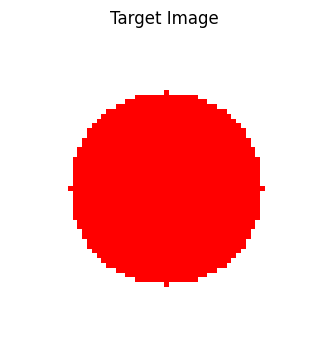

In [17]:
def create_target_circle(size, radius, color):
    y, x = np.ogrid[-size/2:size/2, -size/2:size/2]
    mask = x**2 + y**2 <= radius**2
    img = np.zeros((size, size, 4), dtype=np.float32)
    img[mask] = color
    return img

size = 64
target_img = create_target_circle(size, 20, [1.0, 0.0, 0.0, 1.0])  # Red circle

plt.figure(figsize=(4, 4))
plt.imshow(target_img)
plt.title("Target Image")
plt.axis('off')
plt.show()


#### **Defining the Training Loop**

In [18]:
def train_nca(model, target_img, epochs=5000, lr=2e-3, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    target = torch.from_numpy(target_img).permute(2, 0, 1).unsqueeze(0).to(device)
    losses = []

    # Initialize the grid
    x = torch.zeros(1, model.channel_n, target.shape[2], target.shape[3]).to(device)
    x[:, :4, target.shape[2]//2, target.shape[3]//2] = 1.0  # Seed in the center

    for epoch in tqdm(range(epochs)):
        x.requires_grad_(True)
        for _ in range(8):
            x = model(x)
            x = torch.clamp(x, 0.0, 1.0)
        loss = F.mse_loss(x[:, :4, :, :], target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return model, x.detach(), losses


#### **Training the Model**

In [19]:
model = NeuralCA().to(device)
model, final_state, losses = train_nca(model, target_img, device=device)

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

``` python
model = NeuralCA().to(device)
model, final_state, losses = train_nca(model, target_img, device=device)
```

------------------------------------------------------------------------

## **Visualizing NCA Evolution**

We’ll visualize how the NCA evolves over time to form the target
pattern.

``` python
def visualize_evolution(model, steps=200):
    # Initialize the grid
    x = torch.zeros(1, model.channel_n, size, size).to(device)
    x[:, :4, size//2, size//2] = 1.0  # Seed in the center
    x_history = []

    for _ in range(steps):
        x = model(x)
        x = torch.clamp(x, 0.0, 1.0)
        x_history.append(x[:, :4, :, :].detach().cpu().numpy())

    # Create animation
    fig, ax = plt.subplots()
    ims = []

    for img in x_history[::5]:
        im = ax.imshow(img[0].transpose(1, 2, 0))
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())

visualize_evolution(model)
```

**Output**:

An animation showing the evolution of the NCA from the initial state to
the final pattern.

------------------------------------------------------------------------

## **Advanced NCA Grafting Techniques**

### **Training Multiple NCAs**

We’ll train a second NCA to generate a different pattern.

#### **Creating a Second Target Image**

``` python
target_img2 = create_target_circle(size, 15, [0.0, 0.0, 1.0, 1.0])  # Blue circle

plt.figure(figsize=(4, 4))
plt.imshow(target_img2)
plt.title("Second Target Image")
plt.axis('off')
plt.show()
```

![Second Target Image](attachment:second_target_image.png)

#### **Training the Second Model**

``` python
model2 = NeuralCA().to(device)
model2, final_state2, losses2 = train_nca(model2, target_img2, device=device)
```

### **Spatial Grafting**

We’ll combine the two models by assigning each to different regions of
the grid.

#### **Implementing Spatial Grafting**

``` python
def graft_models(model1, model2, size, steps, device='cpu'):
    # Initialize the grid
    x = torch.zeros(1, model1.channel_n, size, size).to(device)
    x[:, :4, :, :] = 0.5  # Initial state

    # Create masks
    mask1 = torch.zeros(1, 1, size, size).to(device)
    mask1[:, :, :, :size//2] = 1.0  # Left half
    mask2 = 1.0 - mask1  # Right half

    x_history = []

    for _ in range(steps):
        x1 = model1(x)
        x2 = model2(x)
        x = x1 * mask1 + x2 * mask2 + x * (1 - mask1 - mask2)
        x = torch.clamp(x, 0.0, 1.0)
        x_history.append(x[:, :4, :, :].detach().cpu().numpy())

    return x_history

x_history_grafted = graft_models(model, model2, size=size, steps=200, device=device)
```

#### **Visualizing Spatial Grafting**

``` python
def visualize_grafted_evolution(x_history):
    fig, ax = plt.subplots()
    ims = []

    for img in x_history[::5]:
        im = ax.imshow(img[0].transpose(1, 2, 0))
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())

visualize_grafted_evolution(x_history_grafted)
```

**Output**:

An animation showing how the two NCAs interact in their respective
regions and at the boundary.

### **Parameter Grafting**

We can combine the parameters of the two models.

#### **Averaging Model Parameters**

``` python
def average_parameters(model1, model2):
    model_combined = NeuralCA().to(device)
    with torch.no_grad():
        for p1, p2, pc in zip(model1.parameters(), model2.parameters(), model_combined.parameters()):
            pc.copy_((p1 + p2) / 2.0)
    return model_combined

model_combined = average_parameters(model, model2)
```

#### **Visualizing Parameter Grafting**

``` python
def visualize_combined_model(model_combined, steps=200):
    x = torch.zeros(1, model_combined.channel_n, size, size).to(device)
    x[:, :4, size//2, size//2] = 1.0  # Seed in the center
    x_history = []

    for _ in range(steps):
        x = model_combined(x)
        x = torch.clamp(x, 0.0, 1.0)
        x_history.append(x[:, :4, :, :].detach().cpu().numpy())

    # Create animation
    fig, ax = plt.subplots()
    ims = []

    for img in x_history[::5]:
        im = ax.imshow(img[0].transpose(1, 2, 0))
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())

visualize_combined_model(model_combined)
```

**Output**:

An animation showing the behavior of the combined model with averaged
parameters.

### **Dynamic Grafting**

Switch between models during simulation.

#### **Implementing Dynamic Grafting**

``` python
def dynamic_grafting(model1, model2, size, steps, switch_step, device='cpu'):
    x = torch.zeros(1, model1.channel_n, size, size).to(device)
    x[:, :4, size//2, size//2] = 1.0  # Seed in the center
    x_history = []

    for step in range(steps):
        if step < switch_step:
            x = model1(x)
        else:
            x = model2(x)
        x = torch.clamp(x, 0.0, 1.0)
        x_history.append(x[:, :4, :, :].detach().cpu().numpy())

    return x_history

x_history_dynamic = dynamic_grafting(model, model2, size=size, steps=200, switch_step=100, device=device)
```

#### **Visualizing Dynamic Grafting**

``` python
visualize_grafted_evolution(x_history_dynamic)
```

**Output**:

An animation showing how the NCA’s behavior changes when switching from
one model to another during the simulation.

------------------------------------------------------------------------

## **Experiments and Exercises**

1.  **Modify the Target Images**: Try using different shapes or patterns
    as target images, such as squares, letters, or more complex
    drawings.

2.  **Adjust Fire Rates**: Experiment with different `fire_rate` values
    in the `NeuralCA` model (e.g., 0.1, 0.9) and observe how it affects
    the evolution.

3.  **Create Gradient Masks**: Instead of binary masks, use masks with
    gradient values to blend updates smoothly between models in spatial
    grafting.

    ``` python
    # Create a gradient mask
    mask1 = torch.linspace(1.0, 0.0, steps=size).unsqueeze(0).unsqueeze(0).unsqueeze(3).repeat(1, 1, 1, size).to(device)
    mask2 = 1.0 - mask1
    ```

4.  **Train Combined Models**: After grafting models (especially
    parameter grafting), continue training the combined model and see if
    it can learn new patterns or improve existing ones.

5.  **Extend to 3D NCAs**: Modify the code to work with 3D grids and
    visualize the results using volumetric rendering techniques.

------------------------------------------------------------------------

## **Conclusion**

In this notebook, we’ve explored Neural Cellular Automata from basic
implementations to advanced grafting techniques. By combining multiple
NCAs, we can create complex and dynamic patterns that showcase the power
of local interactions leading to emergent global behaviors.

Feel free to experiment further, modify the code, and explore new ideas
in the fascinating world of NCAs.

------------------------------------------------------------------------

**Note**: Make sure to run all the code cells in order to avoid any
errors due to undefined variables or missing dependencies.